### Logistic Regression   - prognozowanie szans przeżycia pasażerów Titanica#

Na podstawie Titanic Data Set który zawiera nasyępujące kolumny:

1. pclass:    Ticket class  
2. survival:    Survival 
3. name:        Imię   
4. sex:    Sex     
5. Age:    Age in years     
6. sibsp:    # of siblings / spouses aboard the Titanic     
7. parch:    # of parents / children aboard the Titanic     
8. ticket:    Ticket number     
9. fare:    Passenger fare     
10. cabin:    Cabin number     
11. embarked:    Port of Embarkation
12. ....


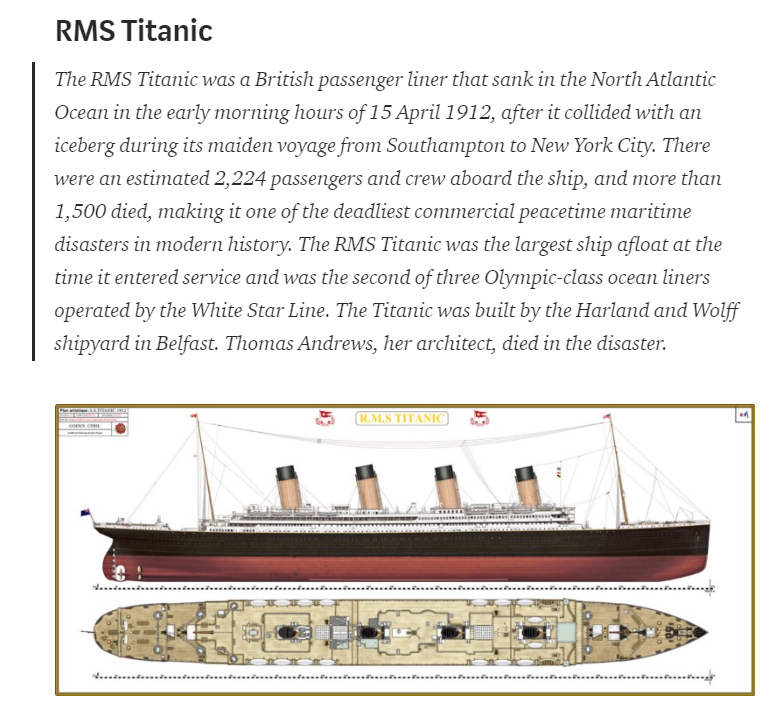

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**Wprowadzenie danych**

In [3]:
titanic = pd.read_csv('titanic3.csv',delimiter=';')

In [4]:
titanic.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN


**EDA**

Missing data

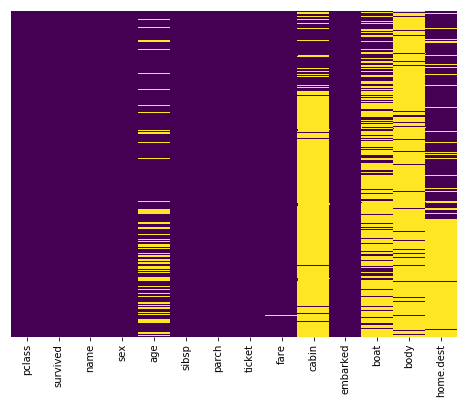

In [5]:
# Ogólna obraz  rozmieszczeniu braku danych
plt.subplots(figsize=(8,6))
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [6]:
# Ile brakuje danych w poszczególnych kolumnach, przegląd
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


**Podstawowa analiza   EDA**

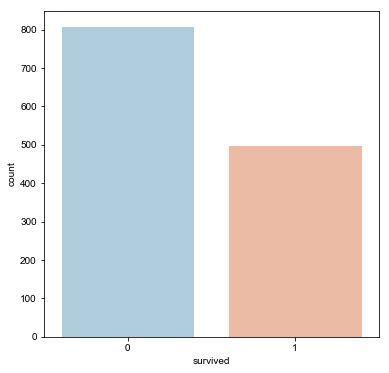

In [7]:
# ilu przeżyło,zginęło 

plt.subplots(figsize=(6,6))
sns.set_style('whitegrid')
sns.countplot(x='survived',data=titanic,palette='RdBu_r');

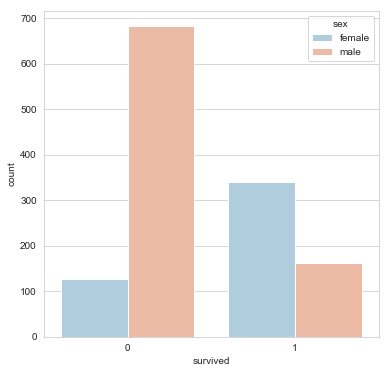

In [8]:
# ilu przeżyło,zginęło  z podzialem na płeć
plt.subplots(figsize=(6,6))
sns.countplot(x='survived',hue='sex',data=titanic,palette='RdBu_r');

In [9]:
# Jaki procent był na statku K i M, jaki procent zginął z podziałem na płeć

print('mężczyzn na statku',round(titanic['sex'][titanic['sex']=='male'].count()/len(titanic)*100,2))
print('kobiet na statku',round(titanic['sex'][titanic['sex']=='female'].count()/len(titanic)*100,2))
print()
mm=titanic['sex'][titanic['sex']=='male'].count()
kk=titanic['sex'][titanic['sex']=='female'].count()
print('mężczyzn na statku zginęło',round(titanic['sex'][(titanic['sex']=='male')&(titanic['survived']==0)].count()/mm*100,2))
print('kobiet na statku zginęło',round(titanic['sex'][(titanic['sex']=='female')&(titanic['survived']==0)].count()/kk*100,2))


mężczyzn na statku 64.4
kobiet na statku 35.6

mężczyzn na statku zginęło 80.9
kobiet na statku zginęło 27.25


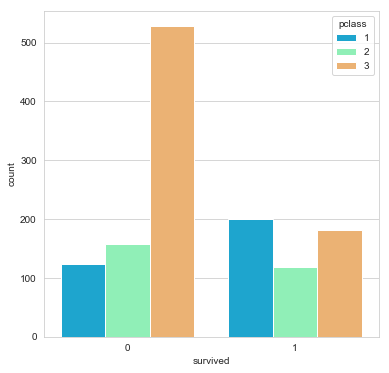

In [10]:
# ofiary ze względu na klasę
plt.subplots(figsize=(6,6))
sns.countplot(x='survived',hue='pclass',data=titanic,palette='rainbow');

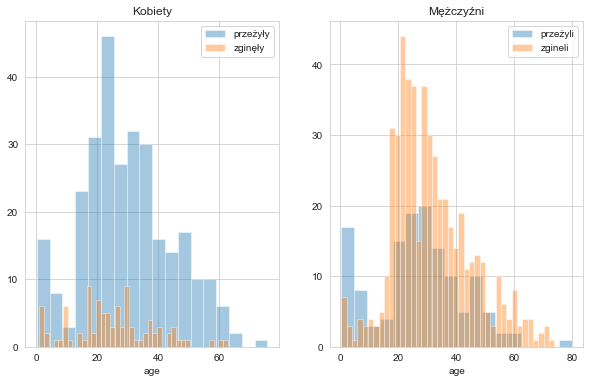

In [11]:
# ofiary ze względu na płeć i wwiek  (przykład kilku rysunków w seaborn)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 6))
women = titanic[titanic['sex']=='female']
men = titanic[titanic['sex']=='male']

ax = sns.distplot(women[women['survived']==1].age.dropna(), bins=18, label = 'przeżyły', ax = axes[0], kde =False)
ax = sns.distplot(women[women['survived']==0].age.dropna(), bins=40, label = 'zginęły', ax = axes[0], kde =False)
ax.legend()
ax.set_title('Kobiety')
ax = sns.distplot(men[men['survived']==1].age.dropna(), bins=18, label = 'przeżyli', ax = axes[1], kde =False)
ax = sns.distplot(men[men['survived']==0].age.dropna(), bins=40, label = 'zgineli', ax = axes[1], kde =False)
ax.legend()
ax.set_title('Mężczyźni');

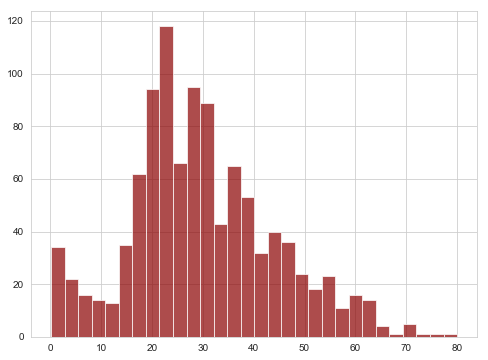

In [12]:
# struktura wieku na statku
plt.subplots(figsize=(8,6))
titanic['age'].dropna().hist(bins=30,color='darkred',alpha=0.7);

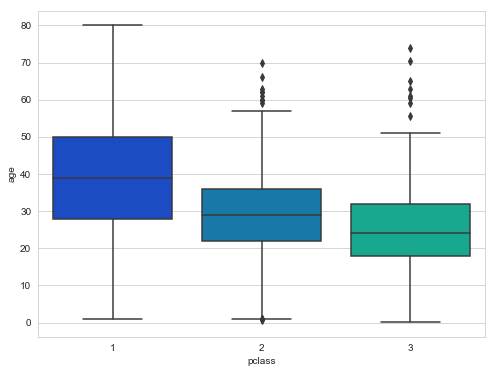

In [13]:
# struktura wieku w 
plt.figure(figsize=(8, 6))
sns.boxplot(x='pclass',y='age',data=titanic,palette='winter')

**Data cleaning**

In [14]:
# obliczamy średni wiek w każdej klasie
print(titanic['age'][titanic['pclass']==1].count(),titanic['age'][titanic['pclass']==1].mean())
print(titanic['age'][titanic['pclass']==2].count(),titanic['age'][titanic['pclass']==2].mean())
print(titanic['age'][titanic['pclass']==3].count(),titanic['age'][titanic['pclass']==3].mean())

284 39.15991795774648
261 29.506704980842912
501 24.81636726546906


In [15]:
# Brakujący wiek zostanie zastąpiony wartością średnią dla danej klasy
# Przykład wstawienia dwóch zmiennych

def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):

        if pclass == 1:
            return 38

        elif pclass == 2:
            return 29

        else:
            return 25

    else:
        return age

In [16]:
titanic['age'] = titanic[['age','pclass']].apply(impute_age,axis=1)

In [17]:
titanic.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [18]:
titanic.drop('cabin',axis=1,inplace=True)
titanic.drop('embarked',axis=1,inplace=True)
titanic.drop('boat',axis=1,inplace=True)
titanic.drop('body',axis=1,inplace=True)
titanic.drop('home.dest',axis=1,inplace=True)
titanic.drop('fare',axis=1,inplace=True)
titanic.drop('name',axis=1,inplace=True)
titanic.drop('ticket',axis=1,inplace=True)

In [19]:
titanic.head()

,pclass,survived,sex,age,sibsp,parch
0,1,1,female,29.0000,0,0
1,1,1,male,0.9167,1,2
2,1,0,female,2.0000,1,2
3,1,0,male,30.0000,1,2
4,1,0,female,25.0000,1,2


In [20]:
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
pclass      1309 non-null int64
survived    1309 non-null int64
sex         1309 non-null object
age         1309 non-null float64
sibsp       1309 non-null int64
parch       1309 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 61.4+ KB


In [21]:
# konwersja danych nienumerycznych w 'sex'
genders={"male":0,"female":1}
titanic['sexx'] = titanic['sex'].map(genders)
titanic.drop('sex',axis=1,inplace=True)
titanic.head(4)

,pclass,survived,age,sibsp,parch,sexx
0,1,1,29.0000,0,0,1
1,1,1,0.9167,1,2,0
2,1,0,2.0000,1,2,1
3,1,0,30.0000,1,2,0


In [22]:
# utworzenie klas wieku w nowym polu

def age_class(x):
    if x<=11:
        return 0
    elif x<=18:
        return 1
    elif x<=23:
        return 2
    elif x<=25:
        return 3
    elif x<=30:
        return 4
    elif x<=35:
        return 5
    elif x<=45:
        return 6    
    else:
        return 7

In [23]:
titanic['agegroup'] = titanic['age'].apply(age_class)

In [24]:
titanic.head()

,pclass,survived,age,sibsp,parch,sexx,agegroup
0,1,1,29.0000,0,0,1,4
1,1,1,0.9167,1,2,0,0
2,1,0,2.0000,1,2,1,0
3,1,0,30.0000,1,2,0,4
4,1,0,25.0000,1,2,1,3


In [25]:
titanic['agegroup'].value_counts()

3    291
6    206
4    182
2    167
7    155
5    115
1    103
0     90
Name: agegroup, dtype: int64

In [26]:
titanic.drop('age',axis=1,inplace=True)
titanic.head()

,pclass,survived,sibsp,parch,sexx,agegroup
0,1,1,0,0,1,4
1,1,1,1,2,0,0
2,1,0,1,2,1,0
3,1,0,1,2,0,4
4,1,0,1,2,1,3


**Building a Logistic Regression model**

Train Test Split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(titanic.drop('survived',axis=1), 
                                                    titanic['survived'], test_size=0.30, 
                                                    random_state=101)

Training and predicting  logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression


In [30]:
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
predictions = logmodel.predict(X_test)

Evaluation

In [32]:
from sklearn.metrics import classification_report


In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       240
           1       0.74      0.68      0.71       153

   micro avg       0.78      0.78      0.78       393
   macro avg       0.77      0.76      0.77       393
weighted avg       0.78      0.78      0.78       393



In [34]:
# jakie czynniki były najważniejsze w uratowaniu

print(X_train.columns)
print(logmodel.coef_)

Index(['pclass', 'sibsp', 'parch', 'sexx', 'agegroup'], dtype='object')
[[-1.07710581 -0.4136481   0.03689868  2.38199216 -0.22531434]]


#### Importowanie biblioteki eli5

conda install -c conda-forge eli5

In [36]:
# jakie czynniki były ważne
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(logmodel, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2285 ± 0.0222,sexx
0.0906 ± 0.0200,pclass
0.0310 ± 0.0162,agegroup
-0.0020 ± 0.0020,parch
-0.0087 ± 0.0220,sibsp


Training and predicting  Support Vector Machine

In [37]:
from sklearn.svm import SVC

In [40]:
model = SVC(gamma='auto')

In [41]:
model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
predictions = model.predict(X_test)

In [43]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       240
           1       0.77      0.73      0.75       153

   micro avg       0.81      0.81      0.81       393
   macro avg       0.80      0.79      0.80       393
weighted avg       0.81      0.81      0.81       393



In [44]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2672 ± 0.0336,sexx
0.0198 ± 0.0149,agegroup
0.0193 ± 0.0069,parch
0.0153 ± 0.0161,sibsp
0.0127 ± 0.0097,pclass


**Optymalizacja SVC**

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_grid = {'C': [0.1,1, 10, 100, 1000],
              'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [47]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [48]:
grid.fit(X_train,y_train)

C:\Users\CentrumGIS\AppData\Local\ESRI\conda\envs\progis\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7091503267973857, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7026143790849673, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6743421052631579, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7483660130718954, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7647058823529411, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7993421052631579, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ............................

[CV]  C=1000, gamma=0.1, kernel=rbf, score=0.7810457516339869, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV]  C=1000, gamma=0.1, kernel=rbf, score=0.7679738562091504, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV]  C=1000, gamma=0.1, kernel=rbf, score=0.7796052631578947, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV]  C=1000, gamma=0.01, kernel=rbf, score=0.8071895424836601, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV]  C=1000, gamma=0.01, kernel=rbf, score=0.7908496732026143, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV]  C=1000, gamma=0.01, kernel=rbf, score=0.7993421052631579, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.7973856209150327, total=   0.0s
[CV] C=1000, gamma=0.001, kern

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    2.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [49]:
grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [51]:
model = SVC(gamma=0.1)
model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
predictions = model.predict(X_test)

In [53]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       240
           1       0.78      0.73      0.75       153

   micro avg       0.81      0.81      0.81       393
   macro avg       0.81      0.80      0.80       393
weighted avg       0.81      0.81      0.81       393



In [54]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2723 ± 0.0339,sexx
0.0219 ± 0.0114,sibsp
0.0198 ± 0.0109,agegroup
0.0188 ± 0.0089,parch
0.0163 ± 0.0094,pclass


Training and predicting Rain Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       240
           1       0.78      0.65      0.71       153

   micro avg       0.79      0.79      0.79       393
   macro avg       0.79      0.77      0.77       393
weighted avg       0.79      0.79      0.79       393



In [59]:
perm = PermutationImportance(rfc, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1776 ± 0.0335,sexx
0.1003 ± 0.0160,pclass
0.0433 ± 0.0211,agegroup
0.0366 ± 0.0181,parch
0.0244 ± 0.0169,sibsp
